# CNNMO: Multi-Output CNN for Side-Channel Attack

This notebook implements the multi-output CNN (CNNMO) architecture for non-profiled side-channel attacks.

**Architecture:**
- Shared CNN backbone (2 conv blocks)
- 256 parallel output heads (one per key hypothesis)

**Supported Datasets:**
- ASCAD
- AES_PTv2_Pinata (MS1, MS2, Unprotected)


In [79]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm


In [80]:
# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


## 1. Load Preprocessed Data

Select which preprocessed dataset to use (should match the dataset used in the data preparation notebook).


In [81]:
# Configuration: Select which preprocessed dataset to load
# Options: "ascad_preprocessed.pt", "pinata_ms1_preprocessed.pt", 
#          "pinata_ms2_preprocessed.pt", "pinata_unprotected_preprocessed.pt"
PREPROCESSED_FILE = "pinata_unprotected_preprocessed.pt"

# Load preprocessed data from notebook 1
# weights_only=False is needed because the file contains numpy objects
data = torch.load(PREPROCESSED_FILE, weights_only=False)

# Training data (profiling traces)
traces = data["traces"]
labels = data["labels"]

# Attack data (for evaluation)
attack_traces = data["attack_traces"]
attack_labels = data["attack_labels"]
attack_plaintexts = data["attack_plaintexts"]

true_key = int(data["true_key"])  # From attack set (fixed secret)
profiling_keys_unique = data.get("profiling_keys_unique")

# Get dataset info if available
dataset_name = data.get("dataset_name", "unknown")
target_byte = data.get("target_byte", "unknown")

print(f"=== Dataset Info ===")
print(f"Dataset: {dataset_name}")
print(f"Target byte: {target_byte}")
print(f"Preprocessed file: {PREPROCESSED_FILE}")

print("\n=== Training Data ===")
print(f"Traces shape: {traces.shape}")
print(f"Labels shape: {labels.shape}")

print("\n=== Attack Data ===")
print(f"Attack traces shape: {attack_traces.shape}")
print(f"Attack labels shape: {attack_labels.shape}")

if profiling_keys_unique is not None:
    print(f"\nProfiling keys unique count: {len(profiling_keys_unique)}")
    print(f"Profiling keys (first 5): {profiling_keys_unique[:5]}")

print(f"\nTrue key (attack device): {true_key}")


=== Dataset Info ===
Dataset: pinata_unprotected
Target byte: 2
Preprocessed file: pinata_unprotected_preprocessed.pt

=== Training Data ===
Traces shape: torch.Size([50000, 1260])
Labels shape: torch.Size([50000, 256])

=== Attack Data ===
Attack traces shape: torch.Size([50000, 1260])
Attack labels shape: torch.Size([50000, 256])

Profiling keys unique count: 256
Profiling keys (first 5): [0 1 2 3 4]

True key (attack device): 186


## 2. CNNMO Model Architecture

Updated backbone:
- 3 dilated Conv1D blocks (wider channels) with BatchNorm, ReLU, pooling
- Global average pooling to a fixed length + dropout
- Single linear layer outputs one logit per key (256 logits) for BCEWithLogitsLoss


In [82]:
class CNNMO(nn.Module):
    """Deeper CNNMO with dilated conv blocks and global pooling."""
    
    def __init__(
        self,
        input_size=700,
        n_keys=256,
        channels=(32, 64, 64),
        kernel_sizes=(33, 17, 9),
        pool_sizes=(2, 2, 2),
        dilations=(1, 2, 4),
        out_len=32,
        dropout=0.3,
    ):
        super().__init__()
        assert len(channels) == len(kernel_sizes) == len(pool_sizes) == len(dilations), "config lengths must match"
        self.n_keys = n_keys

        blocks = []
        in_c = 1
        for c, k, p, d in zip(channels, kernel_sizes, pool_sizes, dilations):
            pad = (k // 2) * d
            blocks.append(
                nn.Sequential(
                    nn.Conv1d(in_c, c, kernel_size=k, dilation=d, padding=pad),
                    nn.BatchNorm1d(c),
                    nn.ReLU(inplace=True),
                    nn.AvgPool1d(p),
                )
            )
            in_c = c
        self.blocks = nn.ModuleList(blocks)
        self.global_pool = nn.AdaptiveAvgPool1d(out_len)
        self.dropout = nn.Dropout(dropout)

        self._flat_size = self._get_flat_size(input_size)
        self.fc = nn.Linear(self._flat_size, n_keys)  # one logit per key

        self._init_weights()
    
    def _get_flat_size(self, input_size):
        x = torch.zeros(1, 1, input_size)
        for block in self.blocks:
            x = block(x)
        x = self.global_pool(x)
        return x.view(1, -1).size(1)
    
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
    
    def forward(self, x):
        if x.dim() == 2:
            x = x.unsqueeze(1)
        for block in self.blocks:
            x = block(x)
        x = self.global_pool(x)
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        logits = self.fc(x)  # (batch, 256)
        return logits


In [83]:
# Create model and verify architecture
input_size = traces.shape[1]
model = CNNMO(input_size=input_size, n_keys=256)
print(f"Input size: {input_size}")
print(f"Flattened size after CNN: {model._flat_size}")
print(f"Output logits: {model.fc.out_features}")

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params:,}")


Input size: 1260
Flattened size after CNN: 2048
Output logits: 256
Total parameters: 597,760


## 3. Training Setup


In [84]:
# Reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Hyperparameters / data settings
TRAIN_TRACES_LIMIT = 20000  # Set None to use all available traces
VAL_FRACTION = 0.1
BATCH_SIZE = 256
EPOCHS = 38
LR = 1e-3
WEIGHT_DECAY = 1e-4
GRAD_CLIP = 1.0
EVAL_EVERY = 2  # How often to compute attack rank (epochs)

# Optionally limit profiling traces for quicker experiments
if TRAIN_TRACES_LIMIT is not None:
    traces = traces[:TRAIN_TRACES_LIMIT]
    labels = labels[:TRAIN_TRACES_LIMIT]

# BCEWithLogitsLoss expects float targets
labels = labels.float()
attack_labels = attack_labels.float()

# Compute per-key pos_weight for class imbalance
pos = labels.sum(dim=0)
neg = labels.size(0) - pos
pos_weight = neg / (pos + 1e-6)
print(f"pos_weight stats (min/median/max): {pos_weight.min():.2f} / {pos_weight.median():.2f} / {pos_weight.max():.2f}")

# Build loaders with a validation split
full_dataset = TensorDataset(traces, labels)
val_len = max(1, int(len(full_dataset) * VAL_FRACTION))
train_len = len(full_dataset) - val_len
train_ds, val_ds = random_split(full_dataset, [train_len, val_len], generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
attack_loader = DataLoader(TensorDataset(attack_traces, attack_labels), batch_size=BATCH_SIZE, shuffle=False)

print(f"Using {train_len} train / {val_len} val traces (limit={TRAIN_TRACES_LIMIT})")
print(f"Batch size: {BATCH_SIZE}, Epochs: {EPOCHS}, LR: {LR}")

pos_weight stats (min/median/max): 0.96 / 1.00 / 1.04
Using 18000 train / 2000 val traces (limit=20000)
Batch size: 256, Epochs: 38, LR: 0.001


In [85]:
# Move model to device
model = model.to(device)

# Optimizer / scheduler
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.5)

# Loss: one logit per key with BCEWithLogits + class balancing
pos_weight = pos_weight.to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)


## 4. Training Loop

For each batch:
1. Forward pass through shared CNN
2. Get predictions from all 256 heads
3. Compute loss for each head (cross-entropy)
4. Sum all 256 losses and backpropagate


In [86]:
def train_epoch(model, dataloader, optimizer, criterion, device, grad_clip=None):
    """Train for one epoch and return average loss + per-key accuracy."""
    model.train()
    total_loss = 0.0
    correct = torch.zeros(256, device=device)
    total = 0
    
    for batch_traces, batch_labels in dataloader:
        batch_traces = batch_traces.to(device)
        batch_labels = batch_labels.to(device)
        
        optimizer.zero_grad()
        logits = model(batch_traces)  # (batch, 256)
        loss = criterion(logits, batch_labels)
        loss.backward()
        
        if grad_clip is not None:
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        optimizer.step()
        
        total_loss += loss.item() * batch_traces.size(0)
        preds = (logits > 0).float()
        correct += (preds == batch_labels).sum(dim=0)
        total += batch_traces.size(0)
    
    avg_loss = total_loss / total
    accuracy = (correct / total).detach().cpu().numpy()
    return avg_loss, accuracy

def evaluate(model, dataloader, criterion, device):
    """Evaluate model: returns average loss and per-key accuracy."""
    model.eval()
    total_loss = 0.0
    correct = torch.zeros(256, device=device)
    total = 0
    
    with torch.no_grad():
        for batch_traces, batch_labels in dataloader:
            batch_traces = batch_traces.to(device)
            batch_labels = batch_labels.to(device)
            logits = model(batch_traces)
            loss = criterion(logits, batch_labels)
            total_loss += loss.item() * batch_traces.size(0)
            preds = (logits > 0).float()
            correct += (preds == batch_labels).sum(dim=0)
            total += batch_traces.size(0)
    
    avg_loss = total_loss / total
    accuracy = (correct / total).detach().cpu().numpy()
    return avg_loss, accuracy

def compute_key_rank(model, dataloader, device, true_key):
    """Compute log-likelihood rank of the true key over a dataloader."""
    model.eval()
    total_loglik = torch.zeros(256, device=device)
    with torch.no_grad():
        for batch_traces, batch_labels in dataloader:
            batch_traces = batch_traces.to(device)
            batch_labels = batch_labels.to(device)
            logits = model(batch_traces)
            # Log-likelihood of observed labels under each key hypothesis
            logp = -nn.functional.binary_cross_entropy_with_logits(logits, batch_labels, reduction='none')
            total_loglik += logp.sum(dim=0)
    scores = total_loglik.detach().cpu().numpy()
    rank = int((scores > scores[true_key]).sum() + 1)
    return rank, scores


In [87]:
# Training loop - track loss/accuracy and attack rank
history = []  # list of dicts per epoch
best_attack_rank = 257  # higher than worst case
best_state = None

for epoch in tqdm(range(1, EPOCHS + 1), desc="Training"):
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device, grad_clip=GRAD_CLIP)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)
    scheduler.step()

    attack_rank = None
    if epoch % EVAL_EVERY == 0:
        attack_rank, _ = compute_key_rank(model, attack_loader, device, true_key)
        if attack_rank < best_attack_rank:
            best_attack_rank = attack_rank
            best_state = {k: v.cpu() for k, v in model.state_dict().items()}
    
    epoch_record = {
        "epoch": epoch,
        "train_loss": train_loss,
        "val_loss": val_loss,
        "train_acc": train_acc,
        "val_acc": val_acc,
        "attack_rank": attack_rank,
    }
    history.append(epoch_record)

    best_key = int(np.argmax(train_acc))
    msg = (f"Epoch {epoch}/{EPOCHS} | train loss {train_loss:.4f} | val loss {val_loss:.4f} | "
           f"best train key {best_key} acc {train_acc[best_key]:.4f} | true key val acc {val_acc[true_key]:.4f}")
    if attack_rank is not None:
        msg += f" | attack rank {attack_rank}"
    print(msg)

if best_state is not None:
    model.load_state_dict(best_state)
    print(f"Loaded best checkpoint with attack rank {best_attack_rank}")
else:
    print("No attack rank improvement checkpoints captured (EVAL_EVERY too large?)")


Training:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 1/38 | train loss 0.7092 | val loss 0.6953 | best train key 62 acc 0.5096 | true key val acc 0.4985
Epoch 2/38 | train loss 0.6965 | val loss 0.6943 | best train key 113 acc 0.5098 | true key val acc 0.4655 | attack rank 68
Epoch 3/38 | train loss 0.6945 | val loss 0.6940 | best train key 175 acc 0.5114 | true key val acc 0.4995
Epoch 4/38 | train loss 0.6938 | val loss 0.6937 | best train key 55 acc 0.5127 | true key val acc 0.5020 | attack rank 238
Epoch 5/38 | train loss 0.6934 | val loss 0.6935 | best train key 168 acc 0.5134 | true key val acc 0.5005
Epoch 6/38 | train loss 0.6932 | val loss 0.6935 | best train key 203 acc 0.5136 | true key val acc 0.4945 | attack rank 161
Epoch 7/38 | train loss 0.6931 | val loss 0.6935 | best train key 19 acc 0.5157 | true key val acc 0.5095
Epoch 8/38 | train loss 0.6930 | val loss 0.6935 | best train key 21 acc 0.5179 | true key val acc 0.5000 | attack rank 162
Epoch 9/38 | train loss 0.6927 | val loss 0.6936 | best train key 181 acc 0.5

## 5. Key Recovery (Training Data)

Check which key hypothesis has the highest accuracy on the training data. Note: this is just a preliminary check - the real attack evaluation happens on unseen attack traces.


In [88]:
# Final evaluation on train/val/attack splits
train_loss_final, train_acc_final = evaluate(model, train_loader, criterion, device)
val_loss_final, val_acc_final = evaluate(model, val_loader, criterion, device)
attack_loss, attack_acc = evaluate(model, attack_loader, criterion, device)
attack_rank, attack_scores = compute_key_rank(model, attack_loader, device, true_key)

recovered_key = int(np.argmax(attack_scores))

print(f"\n{'='*50}")
print(f"KEY RECOVERY RESULT (Attack set)")
print(f"{'='*50}")
print(f"True key:          {true_key} (0x{true_key:02x})")
print(f"Recovered key:     {recovered_key} (0x{recovered_key:02x})")
print(f"True key rank:     {attack_rank} / 256")
print(f"True key accuracy: {attack_acc[true_key]:.4f}")
print(f"Recovered key acc: {attack_acc[recovered_key]:.4f}")
print(f"Train/Val loss:    {train_loss_final:.4f} / {val_loss_final:.4f}")



KEY RECOVERY RESULT (Attack set)
True key:          186 (0xba)
Recovered key:     109 (0x6d)
True key rank:     68 / 256
True key accuracy: 0.5000
Recovered key acc: 0.5045
Train/Val loss:    0.6939 / 0.6943


## 6. Visualization

Plot accuracy curves for all key hypotheses. The correct key should clearly separate from the others.


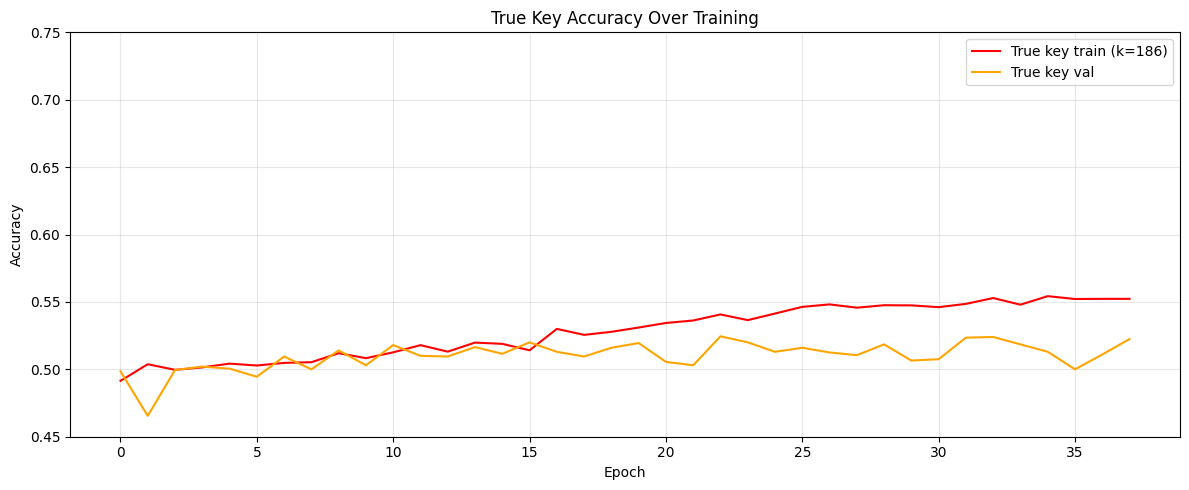

In [89]:
# Convert history to arrays
train_acc_arr = np.stack([h["train_acc"] for h in history])
val_acc_arr = np.stack([h["val_acc"] for h in history])

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(train_acc_arr[:, true_key], label=f'True key train (k={true_key})', color='red')
ax.plot(val_acc_arr[:, true_key], label='True key val', color='orange')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.set_ylim(0.45, 0.75)
ax.set_title('True Key Accuracy Over Training')
ax.grid(True, alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()


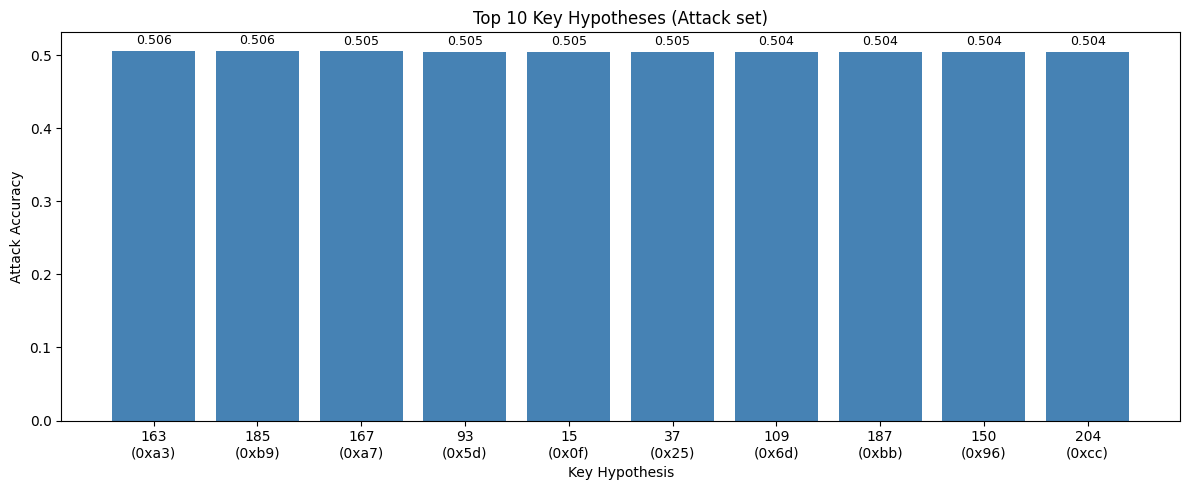

In [90]:
# Final accuracy bar plot on attack set - show top 10 keys
fig, ax = plt.subplots(figsize=(12, 5))

sorted_keys = np.argsort(attack_acc)[::-1]
top_10 = sorted_keys[:10]

colors = ['red' if k == true_key else 'steelblue' for k in top_10]
bars = ax.bar(range(10), attack_acc[top_10], color=colors)

ax.set_xticks(range(10))
ax.set_xticklabels([f'{k}\n(0x{k:02x})' for k in top_10])
ax.set_xlabel('Key Hypothesis')
ax.set_ylabel('Attack Accuracy')
ax.set_title('Top 10 Key Hypotheses (Attack set)')

for i, (bar, k) in enumerate(zip(bars, top_10)):
    label = f'{attack_acc[k]:.3f}'
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, 
            label, ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


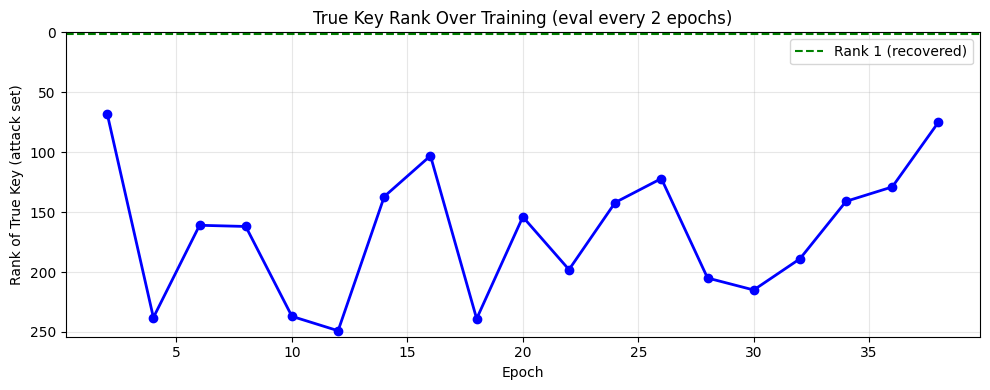

True key reached rank 1 at epoch: Never


In [91]:
# Show rank of true key on attack set across evaluation checkpoints
rank_epochs = [h["epoch"] for h in history if h["attack_rank"] is not None]
rank_values = [h["attack_rank"] for h in history if h["attack_rank"] is not None]

if rank_values:
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(rank_epochs, rank_values, 'b-o', linewidth=2)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Rank of True Key (attack set)')
    ax.set_title(f'True Key Rank Over Training (eval every {EVAL_EVERY} epochs)')
    ax.set_ylim(0, max(rank_values) + 5)
    ax.axhline(y=1, color='green', linestyle='--', label='Rank 1 (recovered)')
    ax.invert_yaxis()
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    reached = [e for e, r in zip(rank_epochs, rank_values) if r == 1]
    print(f"True key reached rank 1 at epoch: {reached[0] if reached else 'Never'}")
else:
    print("No attack rank checkpoints were computed (increase EVAL_EVERY?).")


## 7. Attack Phase - Evaluate on Attack Traces

Now we evaluate the trained model on the **attack traces** (unseen data) to perform the actual key recovery attack. This simulates a real-world scenario where the attacker uses their trained model on a different device.


In [92]:
# Attack-phase summary (using logits-based evaluation above)
print(f"Evaluated on {len(attack_traces)} attack traces")
print(f"Attack loss: {attack_loss:.4f}")
print(f"True key accuracy: {attack_acc[true_key]:.4f}")
print(f"True key rank: {attack_rank} / 256")
print(f"Recovered key (best score): {recovered_key} (0x{recovered_key:02x})")


Evaluated on 50000 attack traces
Attack loss: 0.6943
True key accuracy: 0.5000
True key rank: 68 / 256
Recovered key (best score): 109 (0x6d)


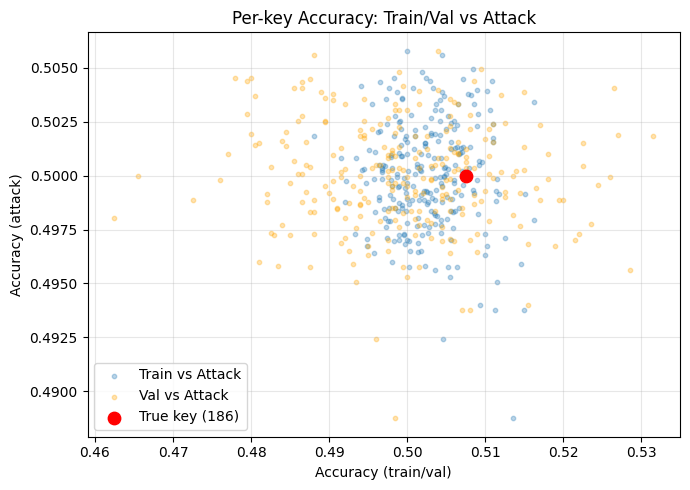

True key rank on attack traces: 68 / 256


In [93]:
# Compare training/val vs attack accuracy for all keys
fig, ax = plt.subplots(figsize=(7, 5))
ax.scatter(train_acc_final, attack_acc, alpha=0.3, s=10, label='Train vs Attack')
ax.scatter(val_acc_final, attack_acc, alpha=0.3, s=10, label='Val vs Attack', color='orange')
ax.scatter([train_acc_final[true_key]], [attack_acc[true_key]], color='red', s=80, label=f'True key ({true_key})', zorder=5)
ax.set_xlabel('Accuracy (train/val)')
ax.set_ylabel('Accuracy (attack)')
ax.set_title('Per-key Accuracy: Train/Val vs Attack')
ax.grid(True, alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()

print(f"True key rank on attack traces: {attack_rank} / 256")


## 8. Summary

Notebook updates:

1. Use a widened CNNMO backbone with dropout and one logit per key hypothesis (BCEWithLogitsLoss).
2. Correct the secret key source (attack set) and carry profiling-key uniqueness info from preprocessing.
3. Add train/val split, gradient clipping, LR scheduler, and rank-based evaluation/checkpointing on attack traces.
4. Visualize true-key trajectories, attack accuracy top-10, and attack rank over epochs.

Re-run the training/eval cells to refresh metrics with the new pipeline and configuration.
